In [1]:
import numpy as np
import xroms
from glob import glob
import matplotlib.pyplot as plt
import gc
import xarray as xr
import pandas as pd
import xrft as xrft
import warnings
import sys
import xrft
# import seaborn as sns
sys.path.append("/homes/metogra/iufarias/FeedbackSubmeso/useful/")
import romspickle

from dask.diagnostics import ProgressBar
import dask
# dask.config.set(**{'array.slicing.split_large_chunks': True})
from dask.distributed import Client, LocalCluster

import scipy.integrate as integ
warnings.filterwarnings("ignore")




/homes/metogra/iufarias/xroms/xroms/interp.py:18: UserWarning: xESMF is not installed, so `interpll` will not run.
  warnings.warn("xESMF is not installed, so `interpll` will not run.")


In [2]:
def calc_MLD(dens_int,fillna=2e20,thresh=0.125,coo='z_rho'):
    '''
    dens_int: Interpolated density xarray (from xroms.isoslice)
    '''
    if coo in dens_int.dims:            
        dens_int_new=dens_int.dropna(coo)
        zdic={'{0}'.format(coo):0}
        mld_dens = dens_int_new.isel(zdic)  + thresh
        
        z_indexes = (abs(dens_int_new - mld_dens)).fillna(fillna).argmin(coo)
        mld_f = dens_int_new[coo][z_indexes]
    else:
        print('z_rho dimension not found')
    
    return mld_f

In [5]:
client = Client(n_workers=90)
# client = Client(cluster)

In [4]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 90
Total threads: 180,Total memory: 502.97 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44139,Workers: 90
Dashboard: http://127.0.0.1:8787/status,Total threads: 180
Started: Just now,Total memory: 502.97 GiB
Comm: tcp://127.0.0.1:45105,Total threads: 2
Dashboard: http://127.0.0.1:43023/status,Memory: 5.59 GiB
Nanny: tcp://127.0.0.1:45073,


## Reading CROCO (3D)

In [6]:
# chunks={'time_counter':10, 'x_rho':50, 'y_rho':190,'s_rho':80,'s_w':80}
chunks={'time_counter':1,'x_rho':1000,"x_u":1000,"x_v":1000,
                        'y_rho':1520,"y_u":1520,"y_v":1520,'s_rho':80,'s_w':80}


path='/data/pacific/lrenault/SASI/CROCO/'

# varf=xr.open_mfdataset(path + 'FULL/SASI*2012-01*.nc',data_vars='minimal',chunks=chunks)
# vart=xr.open_mfdataset(path + 'SMTH/SASI*2012-01*.nc',data_vars='minimal',chunks=chunks)

varf=xr.open_mfdataset(path + 'FULL/SASI*2012*.nc',data_vars='minimal',chunks=chunks)
vart=xr.open_mfdataset(path + 'SMTH/SASI*2012*.nc',data_vars='minimal',chunks=chunks)

In [7]:
varx = varf.rename({"time_counter":"ocean_time","x_rho": "xi_rho","x_u":"xi_u","x_v":"xi_v","x_w":"xi_w",
                    "y_rho":"eta_rho","y_v":"eta_v","y_u":"eta_u","y_w":"eta_w","s_rho":"s_rho","s_w":"s_w"})
df,gf=xroms.roms_dataset(varx,Vtransform=varx.Vtransform.data)

vary = vart.rename({"time_counter":"ocean_time","x_rho": "xi_rho","x_u":"xi_u","x_v":"xi_v",
                    "y_rho":"eta_rho","y_v":"eta_v","y_u":"eta_u","y_w":"eta_w","s_rho":"s_rho","s_w":"s_w"})
dt,gt=xroms.roms_dataset(vary,Vtransform=vary.Vtransform.data)

In [8]:

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 22})

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Lucida Grande']

In [9]:
timer_h=pd.DatetimeIndex(dt.ocean_time)
timer_d=pd.DatetimeIndex(dt.ocean_time.groupby("ocean_time.dayofyear").mean())

In [10]:
rho_full=df.rho[:,:,120:-120,120:800]
rho_smth=dt.rho[:,:,120:-120,120:800]

In [11]:
z_interp=np.linspace(-1,-100, 200)

In [12]:
z=rho_full.z_rho0.compute()

In [13]:
day_x=10

In [14]:
%%time
rho_full_interp=rho_full[day_x,:,:,:].xroms.isoslice(z_interp).compute()

CPU times: user 5.94 s, sys: 3.61 s, total: 9.55 s
Wall time: 19.8 s


In [15]:
mld_rho=calc_MLD(rho_full_interp)
mld_kpp=varf.hbl[day_x,120:-120,120:800]

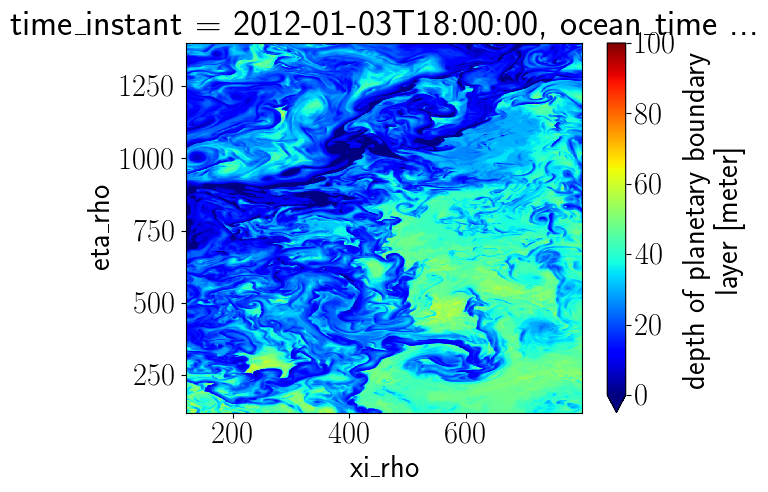

In [16]:
df.hbl[day_x,120:-120,120:800].plot(vmin=0,vmax=100,cmap='jet')

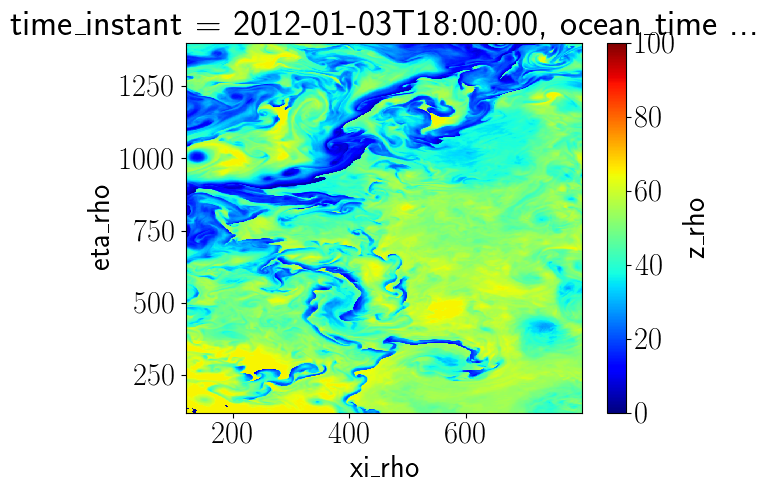

In [17]:
(-calc_MLD(rho_full_interp)).plot(vmin=0,vmax=100,cmap='jet')

Text(0.5, 1.0, '')

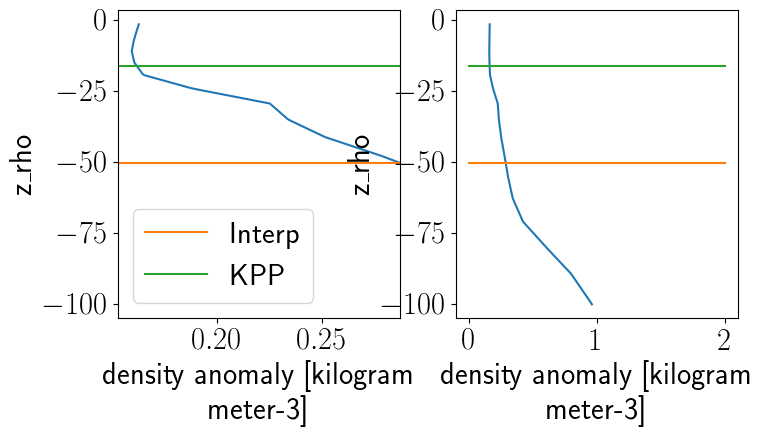

In [20]:
loc_y=250
loc_x=5
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
rho_full_interp[:,loc_y,loc_x].plot(y='z_rho')
plt.plot([0,2],[mld_rho[loc_y,loc_x],mld_rho[loc_y,loc_x]],label='Interp')

plt.plot([0,2],[-mld_kpp[loc_y,loc_x],-mld_kpp[loc_y,loc_x]],label='KPP')
plt.xlim(-0.01+rho_full_interp[1,loc_y,loc_x],rho_full_interp[1,loc_y,loc_x]+0.125)
# plt.xlim(0.15,0.3)
plt.legend()

plt.title('')
plt.subplot(1,2,2)
rho_full_interp[:,loc_y,loc_x].plot(y='z_rho')
plt.plot([0,2],[mld_rho[loc_y,loc_x],mld_rho[loc_y,loc_x]])

plt.plot([0,2],[-mld_kpp[loc_y,loc_x],-mld_kpp[loc_y,loc_x]])
# plt.xlim(-0.01+rho_full_interp[0,loc_y,loc_x],rho_full_interp[0,loc_y,loc_x]+0.125)
plt.title('')



In [26]:
dec=1
MLD_full=xr.DataArray(coords=(df.ocean_time[::dec],
                         range(df.rho[:,:,120:-120,120:800].shape[2]),
                         range(df.rho[:,:,120:-120,120:800].shape[3])),
                      dims=['ocean_time','eta_rho','xi_rho'])
MLD_smth=xr.DataArray(coords=(dt.ocean_time[::dec],
                         range(df.rho[:,:,120:-120,120:800].shape[2]),
                         range(df.rho[:,:,120:-120,120:800].shape[3])),
                      dims=['ocean_time','eta_rho','xi_rho'])

In [27]:
%%time
for ix in range(df.rho[::dec].shape[0]):
    rho_full_interp_d=rho_full[::dec][ix].xroms.isoslice(z_interp).compute()
    MLD_full[ix,:,:]=(-calc_MLD(rho_full_interp_d)).data


2024-01-02 14:24:35,206 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 4.00 GiB -- Worker memory limit: 5.59 GiB
2024-01-02 14:24:35,207 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 4.01 GiB -- Worker memory limit: 5.59 GiB
2024-01-02 14:25:30,337 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- U

CPU times: user 50min 28s, sys: 29min 34s, total: 1h 20min 3s
Wall time: 2h 16min 57s


In [28]:
MLD_full.to_netcdf('/homes/metogra/iufarias/Documents/data/MLD/MLD_full_maps.nc','w')


In [29]:
MLD_full=xr.open_dataset('/homes/metogra/iufarias/Documents/data/MLD/MLD_full_maps.nc')['__xarray_dataarray_variable__']

In [30]:
%%time
for ix in range(dt.rho[::dec].shape[0]):
    rho_smth_interp_d=rho_smth[::dec][ix].xroms.isoslice(z_interp).compute()

    MLD_smth[ix,:,:]=(-calc_MLD(rho_smth_interp_d)).data

2024-01-02 15:57:08,231 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 4.04 GiB -- Worker memory limit: 5.59 GiB
2024-01-02 15:57:19,212 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 4.03 GiB -- Worker memory limit: 5.59 GiB
2024-01-02 15:58:03,627 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- U

CPU times: user 48min 39s, sys: 28min 47s, total: 1h 17min 26s
Wall time: 2h 14min 29s


In [35]:
ix

727

In [32]:
MLD_smth.to_netcdf('/homes/metogra/iufarias/Documents/data/MLD/MLD_smth_maps.nc')

In [33]:
MLD_smth=xr.open_dataset('/homes/metogra/iufarias/Documents/data/MLD/MLD_smth_maps.nc')['__xarray_dataarray_variable__']

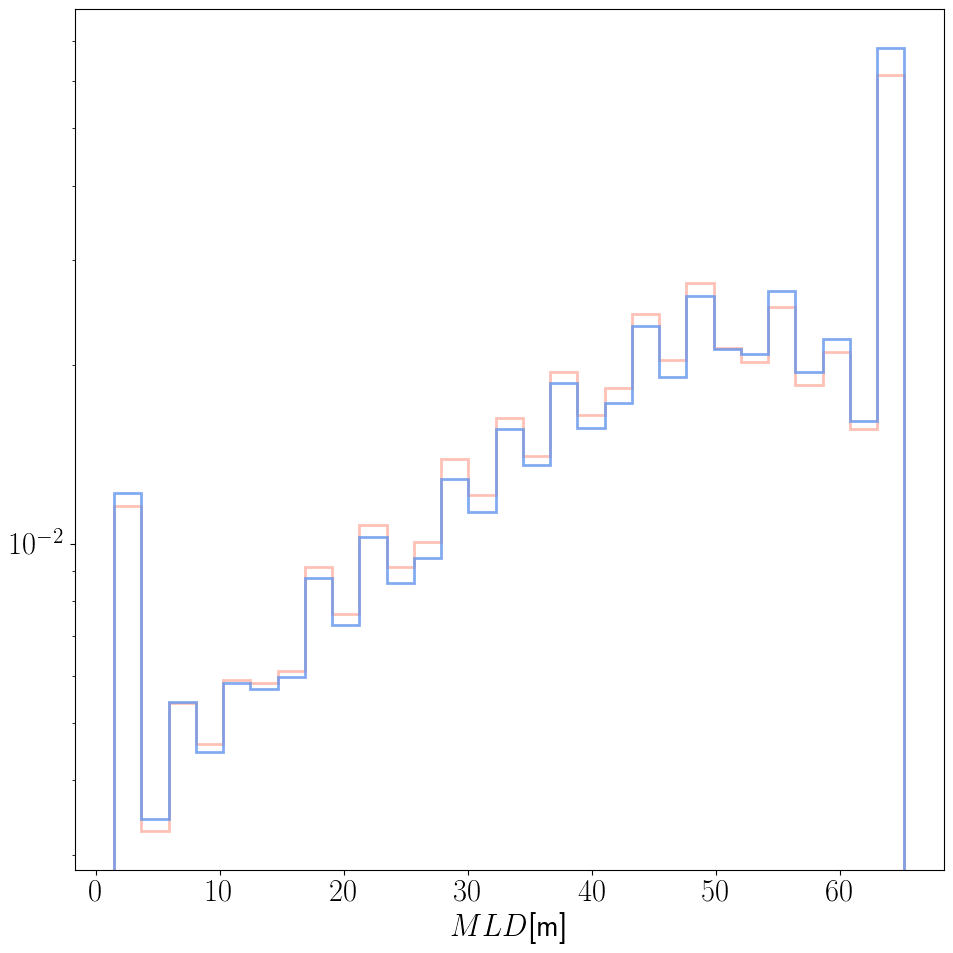

In [39]:
dbool=True
slog=True

a1=0.8
a2=0.4
lw=2
HT='step'

plt.figure(figsize=(10,10))
plt.hist(np.ravel((MLD_full)),bins=29,color='tomato',linewidth=lw,histtype=HT,alpha=a2,density=dbool,log=slog)
plt.hist(np.ravel((MLD_smth)),bins=29,color='cornflowerblue',linewidth=lw,histtype=HT,alpha=a1,density=dbool,log=slog)
plt.xlabel(r'$MLD$[m]')

# plt.xlim(2,70)
plt.tight_layout()
# plt.savefig(